In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

In [13]:
seed = 123
np.random.seed(seed)

In [5]:
train = pd.read_csv('/Users/mathildenordli/Desktop/Master project/csv_files_harmonized/balanced_train.csv') 
test = pd.read_csv('/Users/mathildenordli/Desktop/Master project/csv_files_harmonized/test.csv')
val = pd.read_csv('/Users/mathildenordli/Desktop/Master project/csv_files_harmonized/val.csv')

In [6]:
feature_sets = {
    'Baseline-Post': ['CD45', 'CD185', 'CD45RA', 'CD3', 'CD235ab'],
    'Baseline-Healthy': ['CD45', 'CD45RA', 'CD44', 'CD3', 'CD185'],
    'Post-Healthy': ['CD235ab', 'CD194', 'CD127', 'CD44', 'CD38']
}
marker_columns = list(set([f for sublist in feature_sets.values() for f in sublist]))

In [7]:
train[marker_columns] = np.arcsinh(train[marker_columns]/5)
val[marker_columns] = np.arcsinh(val[marker_columns]/5)
test[marker_columns] = np.arcsinh(test[marker_columns]/5)

In [8]:
train['id_split'] = train.apply(lambda row: f"{row['id']}_{row['group']}", axis=1)
val['id_split'] = val.apply(lambda row: f"{row['id']}_{row['group']}", axis=1)
test['id_split'] = test.apply(lambda row: f"{row['id']}_{row['group']}", axis=1)

train['id_numeric'], _ = pd.factorize(train['id_split'])
val['id_numeric'], _ = pd.factorize(val['id_split'])
test['id_numeric'], _ = pd.factorize(test['id_split'])

In [9]:
train['group'] = train['group'].map({'baseline': 0, 'post': 1, 'healthy': 2})
val['group'] = val['group'].map({'baseline': 0, 'post': 1, 'healthy': 2})
test['group'] = test['group'].map({'baseline': 0, 'post': 1, 'healthy': 2})

In [10]:
results = []

In [11]:
results = []

# trying depths from 1-8
depths = list(range(1, 9))  # shallower trees first
final_model = None
final_features = None
final_depth = None

best_num_features = float('inf')
best_depth = float('inf')

In [14]:
for r in range(1, 5):  # top r features from each group
    print(f'\nTrying top {r} features from each group set')

    # taking the first r features from each list 
    selected_features = feature_sets['Baseline-Post'][:r] + \
                        feature_sets['Baseline-Healthy'][:r] + \
                        feature_sets['Post-Healthy'][:r]
    
    combined_features = list(set(selected_features))  # remove duplicates

    for depth in depths:
        model = DecisionTreeClassifier(max_depth=depth, random_state=seed)

        X_train = train[combined_features]
        y_train = train['group']
        X_val = val[combined_features]
        y_val = val['group']

        model.fit(X_train, y_train)
        val['group_pred'] = model.predict(X_val)

        patient_predictions_noisy = val.groupby('id_numeric')['group_pred'].agg(
            lambda x: x.mode()[0] if len(x.mode()) > 0 else x.values[0]
        ).reset_index()

        y_val_patient = val.groupby('id_numeric')['group'].first().reset_index()
        patient_predictions_noisy = patient_predictions_noisy.merge(y_val_patient, on='id_numeric')

        patient_accuracy = accuracy_score(patient_predictions_noisy['group'], patient_predictions_noisy['group_pred'])

        print(f' features: {combined_features}, depth: {depth}, patient accuracy: {patient_accuracy:.3f}')

        if patient_accuracy == 1.0:
            num_features = len(combined_features)
            if (depth < best_depth) or (depth == best_depth and num_features < best_num_features):
                final_model = model
                final_features = combined_features
                final_depth = depth
                best_num_features = num_features
                best_depth = depth
                print(final_model,' new best model with 1.0 accuracy')


Trying top 1 features from each group set
 features: ['CD45', 'CD235ab'], depth: 1, patient accuracy: 0.444
 features: ['CD45', 'CD235ab'], depth: 2, patient accuracy: 0.556
 features: ['CD45', 'CD235ab'], depth: 3, patient accuracy: 0.556
 features: ['CD45', 'CD235ab'], depth: 4, patient accuracy: 0.556
 features: ['CD45', 'CD235ab'], depth: 5, patient accuracy: 0.667
 features: ['CD45', 'CD235ab'], depth: 6, patient accuracy: 0.556
 features: ['CD45', 'CD235ab'], depth: 7, patient accuracy: 0.667
 features: ['CD45', 'CD235ab'], depth: 8, patient accuracy: 0.667

Trying top 2 features from each group set
 features: ['CD235ab', 'CD194', 'CD185', 'CD45RA', 'CD45'], depth: 1, patient accuracy: 0.444
 features: ['CD235ab', 'CD194', 'CD185', 'CD45RA', 'CD45'], depth: 2, patient accuracy: 0.556
 features: ['CD235ab', 'CD194', 'CD185', 'CD45RA', 'CD45'], depth: 3, patient accuracy: 0.556
 features: ['CD235ab', 'CD194', 'CD185', 'CD45RA', 'CD45'], depth: 4, patient accuracy: 0.667
 features:

In [15]:
print(final_model, final_features)

DecisionTreeClassifier(max_depth=7, random_state=123) ['CD235ab', 'CD127', 'CD194', 'CD44', 'CD185', 'CD45RA', 'CD3', 'CD45']


In [16]:
print(best_depth)

7


In [17]:
X_test = test[final_features]
test['group_pred'] = final_model.predict(X_test)

patient_predictions_noisy = test.groupby('id_numeric')['group_pred'].agg(lambda x: x.mode()[0]).reset_index()
y_test_patient = test.groupby('id_numeric')['group'].first().reset_index()
patient_predictions_noisy = patient_predictions_noisy.merge(y_test_patient, on='id_numeric')

test_patient_accuracy_noisy = accuracy_score(patient_predictions_noisy['group'], patient_predictions_noisy['group_pred'])
print(f"Final patient accuracy on test: {test_patient_accuracy_noisy}")

Final patient accuracy on test: 1.0


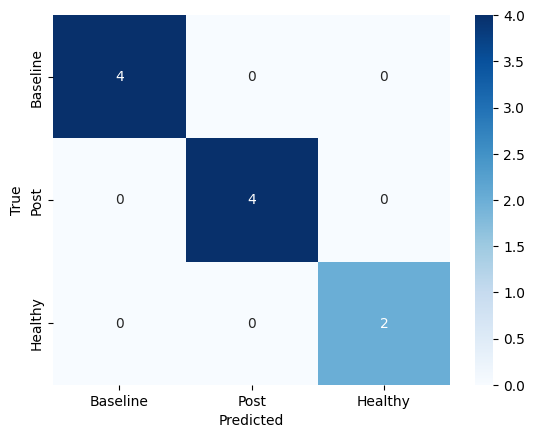

In [18]:
conf_matrix = confusion_matrix(patient_predictions_noisy['group'], patient_predictions_noisy['group_pred'])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Baseline', 'Post', 'Healthy'], yticklabels=['Baseline', 'Post', 'Healthy'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

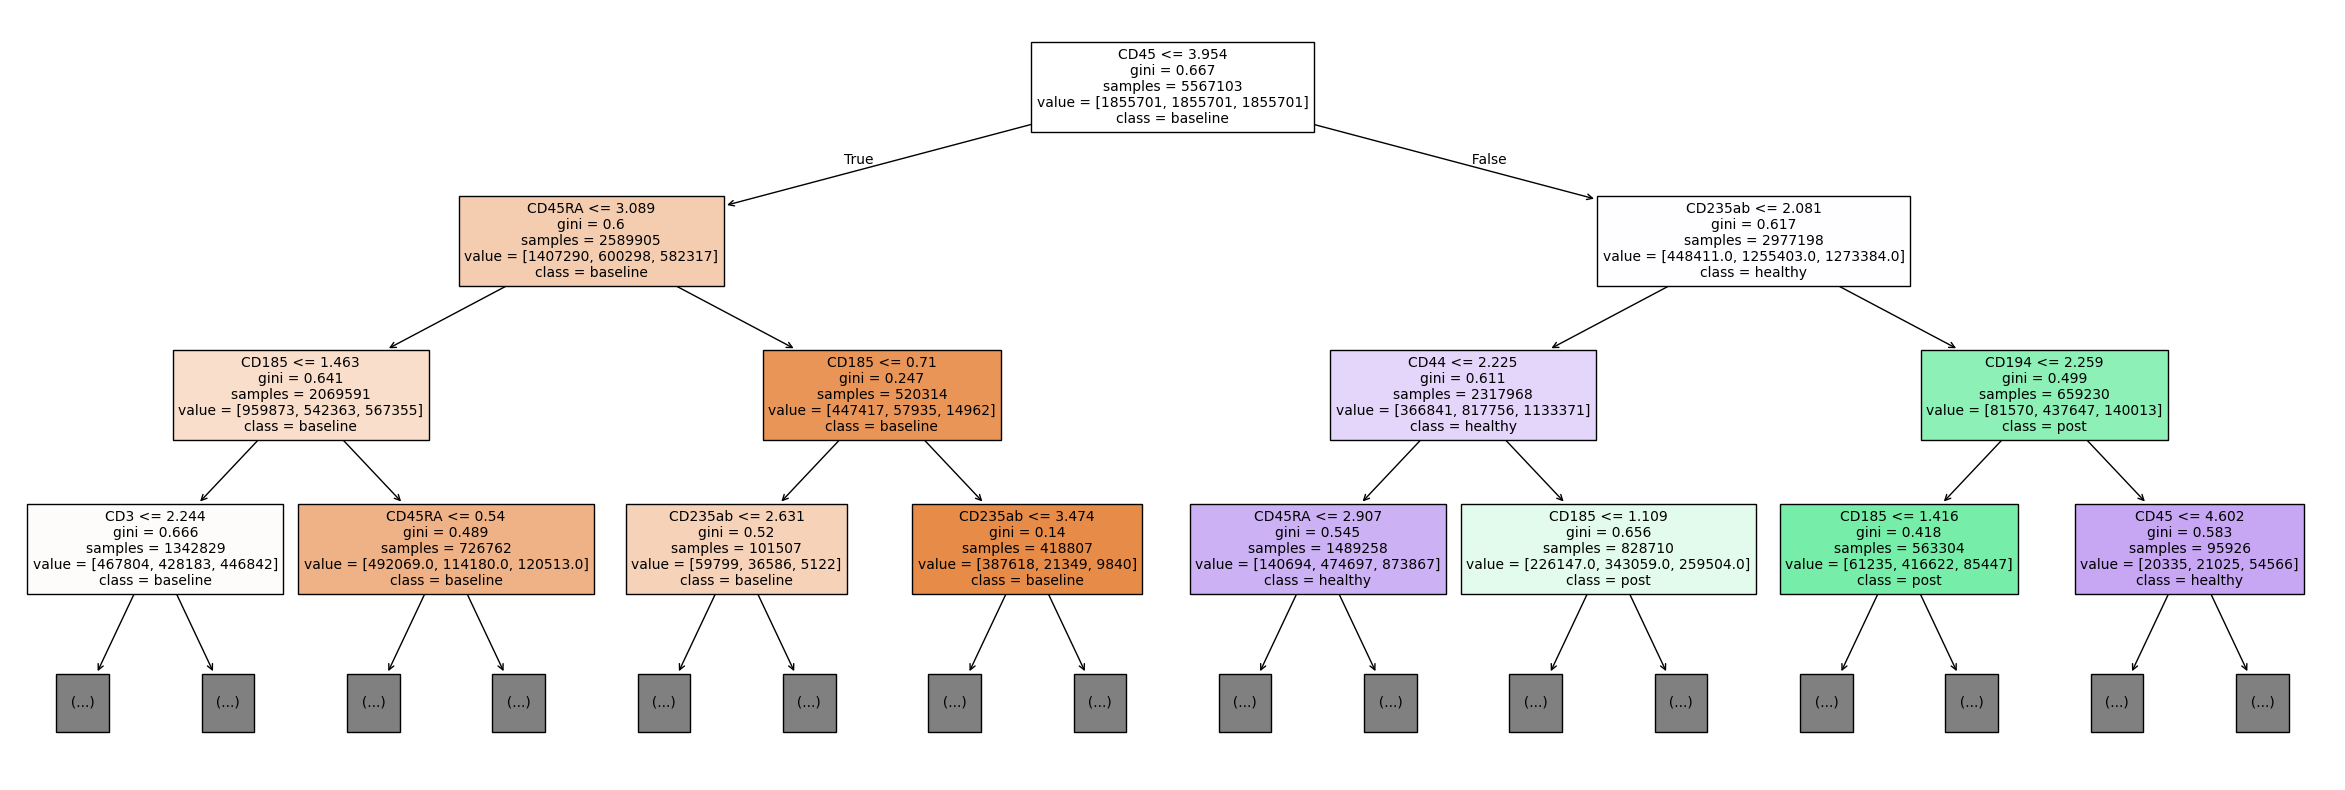

In [19]:
plt.figure(figsize=(30,10))
plot_tree(final_model, feature_names=final_features, class_names=['baseline', 'post', 'healthy'], filled=True, max_depth=3, fontsize=10, )
plt.show()

In [20]:
patient_accuracy = accuracy_score(patient_predictions_noisy['group'], patient_predictions_noisy['group_pred'])
print('Patient test accuracy:', patient_accuracy)

Patient test accuracy: 1.0


In [21]:
def plot_and_split(data, feature, cutoff):
    plt.figure(figsize=(10, 6))

    color_map = {
        0: '#e58139',  
        1: '#8dd3c7',  
        2: '#bebada'   
    }


    label_names = {0: 'Baseline', 1: 'Post', 2: 'Healthy'}

    for label in [0, 1, 2]:
        sns.kdeplot(
            data[data['group'] == label][feature],
            label=label_names[label],
            fill=True,
            color=color_map[label],
            alpha=0.5,
            linewidth=2
        )

    plt.axvline(x=cutoff, color='red', linestyle='--', label=f'Cutoff at {cutoff:.3f}')
    plt.xlabel(f'{feature} expression')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    data_below = data[data[feature] <= cutoff]
    data_above = data[data[feature] > cutoff]

    return data_below, data_above


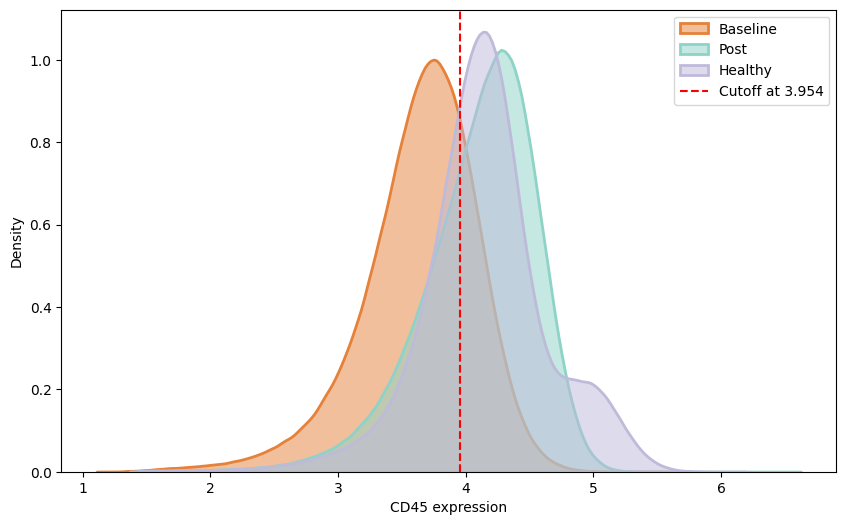

In [22]:
data_below_cd45, data_above_cd45 = plot_and_split(train, 'CD45', 3.954)

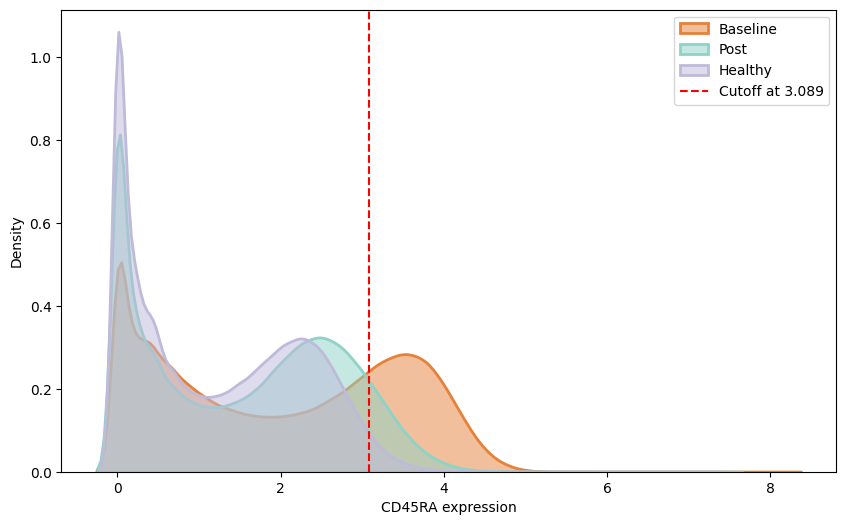

In [23]:
data_below_cd45ra, data_above_cd45ra = plot_and_split(data_below_cd45, 'CD45RA', 3.089)

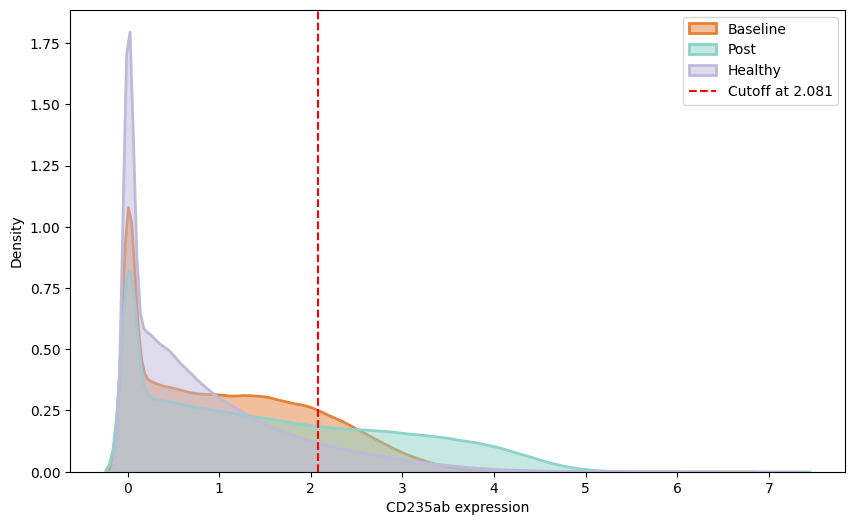

In [24]:
data_below_cd235ab, data_above_cd235ab = plot_and_split(data_above_cd45, 'CD235ab', 2.081, ) 

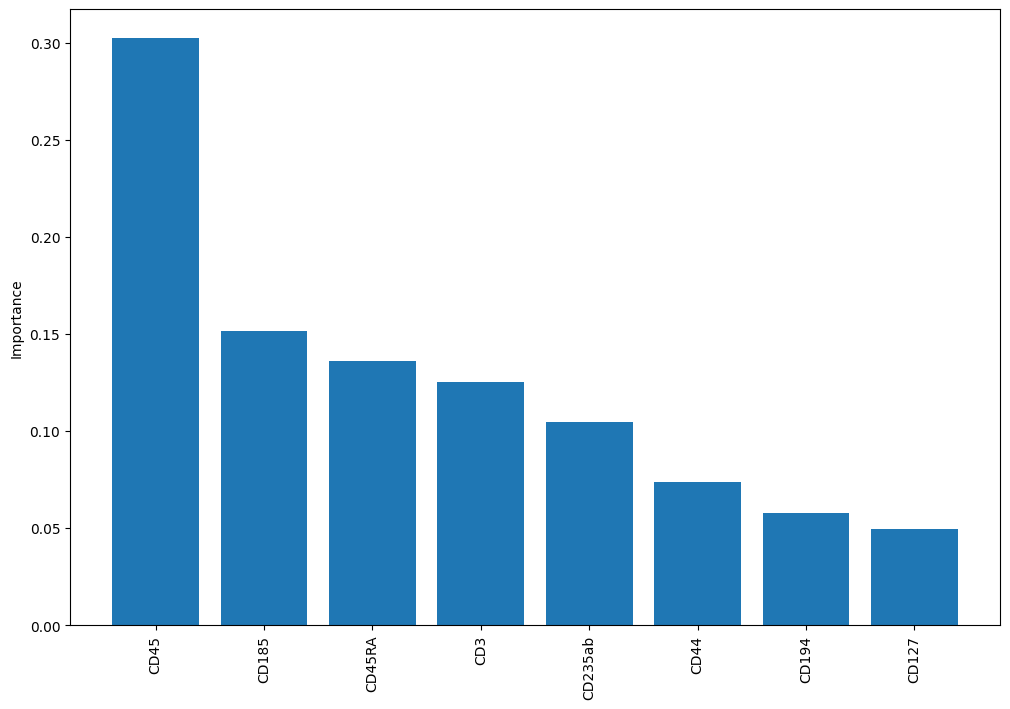

In [25]:
importances = final_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': final_features,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))  
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.ylabel('Importance')
plt.xticks(rotation=90)  
plt.show()

In [26]:
# checking the robustness of the model
def add_gaussian_noise(data, columns, noise_level):
    noisy_data = data.copy()
    noise = np.random.normal(loc=0.0, scale=noise_level, size=noisy_data[columns].shape) 
    noisy_data[columns] += noise
    return noisy_data

In [27]:
noise_levels = [0.1, 0.2, 0.3, 0.4, 0.5]
accuracies = [] 

for noise_level in noise_levels:
    noisy_test = add_gaussian_noise(test, final_features, noise_level)
    noisy_test['group_pred'] = final_model.predict(noisy_test[final_features])

    patient_predictions_noisy = noisy_test.groupby('id_numeric')['group_pred'].agg(lambda x: x.mode()[0]).reset_index()
    y_test_patient = noisy_test.groupby('id_numeric')['group'].first().reset_index()
    patient_predictions_noisy = patient_predictions_noisy.merge(y_test_patient, on='id_numeric')

    test_patient_accuracy_noisy = accuracy_score(patient_predictions_noisy['group'], patient_predictions_noisy['group_pred'])
    accuracies.append(test_patient_accuracy_noisy)
    print(f'Noise level {noise_level}: Test patient accuracy: {test_patient_accuracy_noisy:.3f}')

Noise level 0.1: Test patient accuracy: 1.000
Noise level 0.2: Test patient accuracy: 1.000
Noise level 0.3: Test patient accuracy: 1.000
Noise level 0.4: Test patient accuracy: 1.000
Noise level 0.5: Test patient accuracy: 0.900


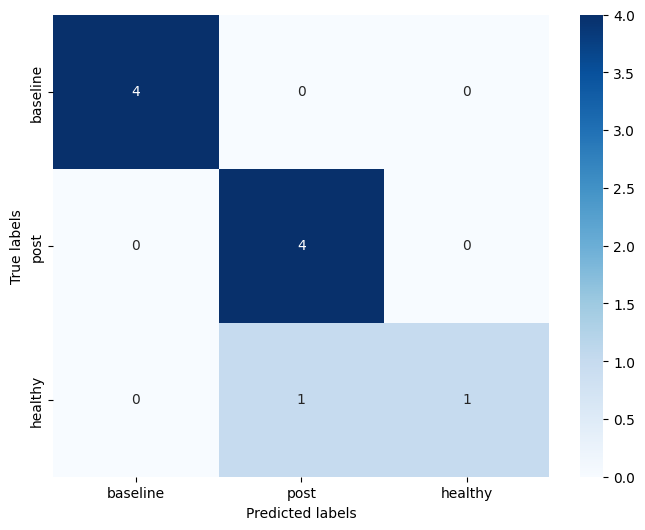

In [28]:
conf_matrix_patient_noisy = confusion_matrix(patient_predictions_noisy['group'], patient_predictions_noisy['group_pred'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_patient_noisy, annot=True, fmt='d', cmap='Blues', xticklabels=['baseline', 'post', 'healthy'], yticklabels=['baseline', 'post', 'healthy'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [29]:
def compute_prediction_proportions(data, model, columns, group_labels):
    predictions = []
    group_names = []
    
    for _, group in data.groupby('id_numeric'):
        X_patient = group[columns]
        y_pred = model.predict(X_patient)
        pred_counts = np.bincount(y_pred, minlength=len(group_labels))
        pred_percentages = 100 * pred_counts / sum(pred_counts)
        predictions.append(pred_percentages)
        group_names.append(group_labels[group['group'].iloc[0]])  

    propotions = pd.DataFrame(predictions, columns=[group_labels[i] for i in range(len(group_labels))])
    propotions['Group'] = group_names  
    return propotions

/var/folders/yv/jfmz17y11sq2sq969g77_8180000gn/T/ipykernel_78780/2071104266.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = predictions_df.drop('Group', axis=1).applymap(lambda x: f"{x:.1f}%")


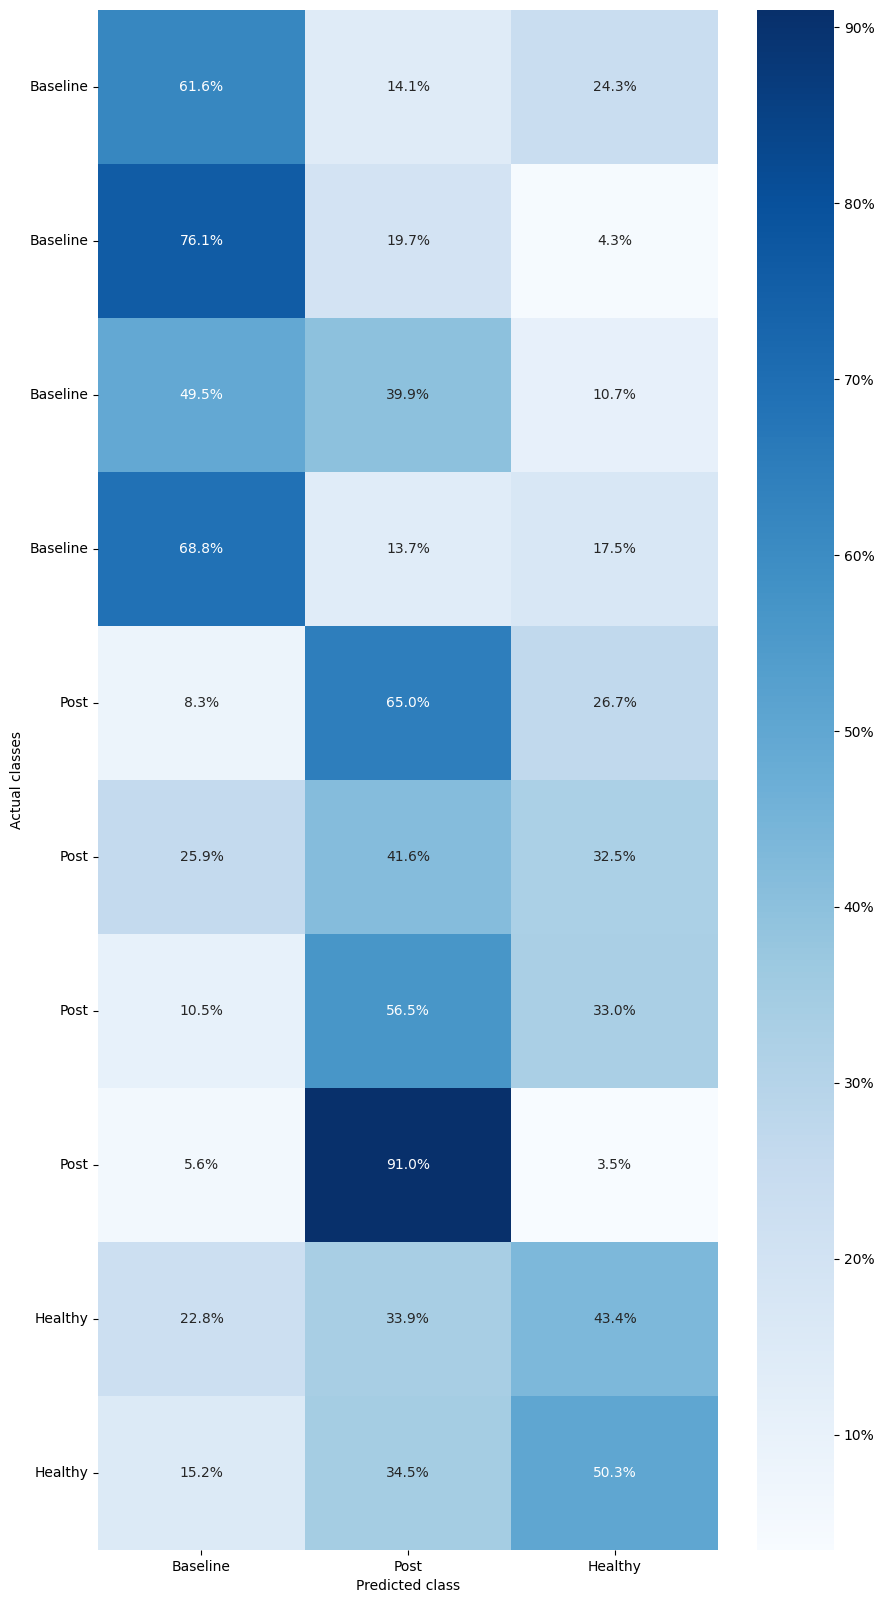

In [30]:
group_labels = {0: 'Baseline', 1: 'Post', 2: 'Healthy'}
predictions_df = compute_prediction_proportions(test, final_model, final_features, group_labels)

annot = predictions_df.drop('Group', axis=1).applymap(lambda x: f"{x:.1f}%")

plt.figure(figsize=(10, 20))
sns.heatmap(predictions_df.drop('Group', axis=1), annot=annot, fmt="", cmap='Blues', cbar_kws={'format': '%.0f%%'})
plt.ylabel('Actual classes')
plt.xlabel('Predicted class')

plt.yticks(ticks=np.arange(0.5, len(predictions_df.index), 1), labels=predictions_df['Group'], rotation=0)

plt.show() 

In [31]:
tsne_columns = [col for col in test.columns if col.startswith('CD') or col.startswith('HLA-DR')]  # using more columns for tsne visualization
X_test_tsne = test[tsne_columns]
X_test_sample = X_test_tsne.sample(n=100000, random_state=seed)  

tsne = TSNE(n_components=2, random_state=seed, perplexity=30)
X_test_tsne = tsne.fit_transform(X_test_sample)  

tsne_data = pd.DataFrame(X_test_tsne, columns=['tsne1', 'tsne2'], index=X_test_sample.index)

test = test.drop(columns=['tsne1', 'tsne2'], errors='ignore')

test = test.join(tsne_data, how='left')  # align by index

In [32]:
def visualize_tsne_predictions(patient_id, data, model, columns, labels_map, sample_size=1000):
    patient_data = data[(data['id_numeric'] == patient_id) & (~data['tsne1'].isna())]
    X_patient = patient_data[columns]

    if len(X_patient) > sample_size:
        X_patient_sample = X_patient.sample(n=sample_size, random_state=123)
    else:
        X_patient_sample = X_patient

    predicted_labels = model.predict(X_patient_sample)
    
    tsne = TSNE(n_components=2, random_state=123)
    tsne_results = tsne.fit_transform(X_patient_sample)

    plt.figure(figsize=(8, 6))
    colors = ['#e58139', '#8dd3c7', '#bebada' ]  
    for label in np.unique(predicted_labels):
        indices = predicted_labels == label
        plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], color=colors[label], label=labels_map[label], alpha=0.5)
    plt.title(labels_map[patient_data.iloc[0]["group"]])
    plt.xlabel('tsne1')
    plt.ylabel('tsne2')
    plt.legend()
    plt.show()

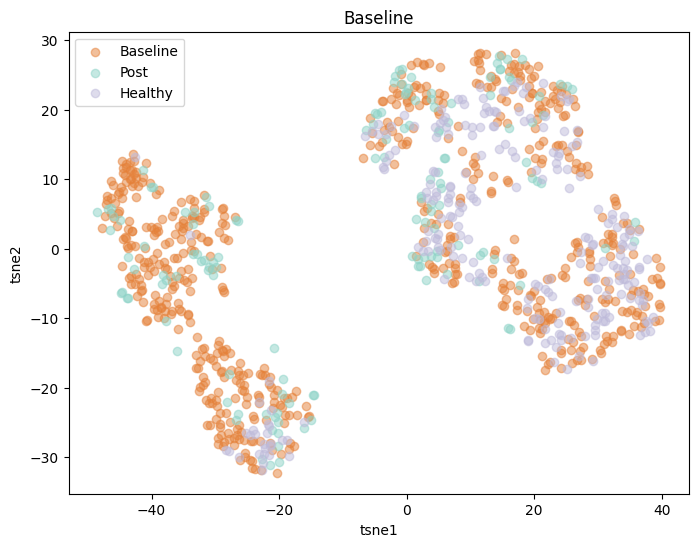

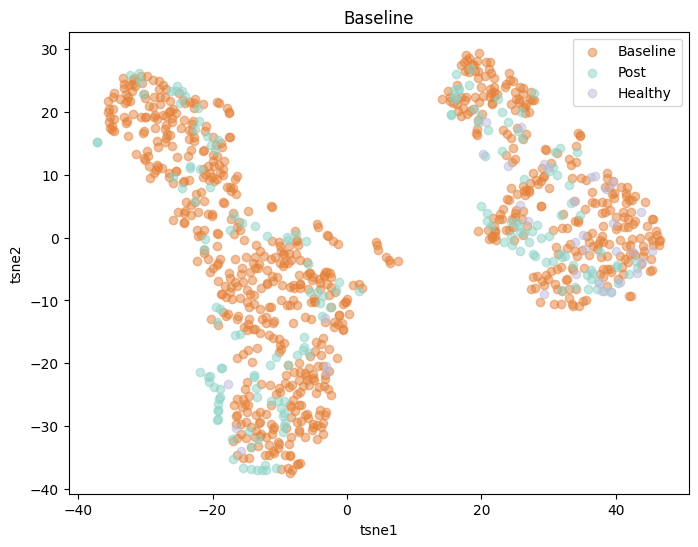

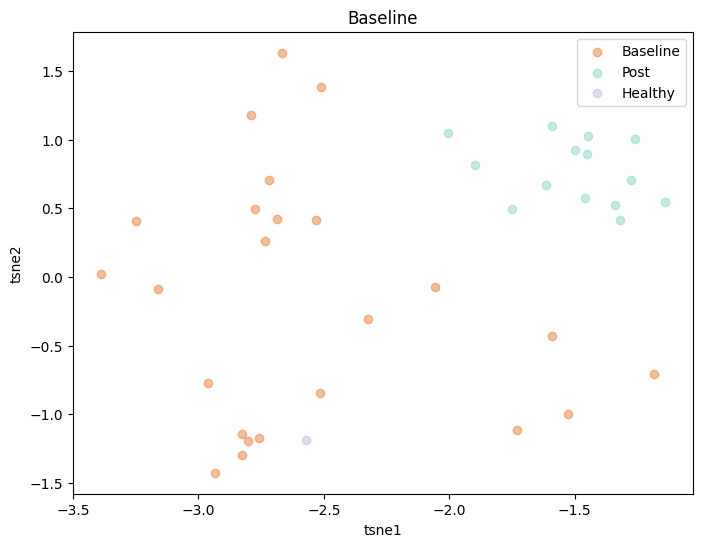

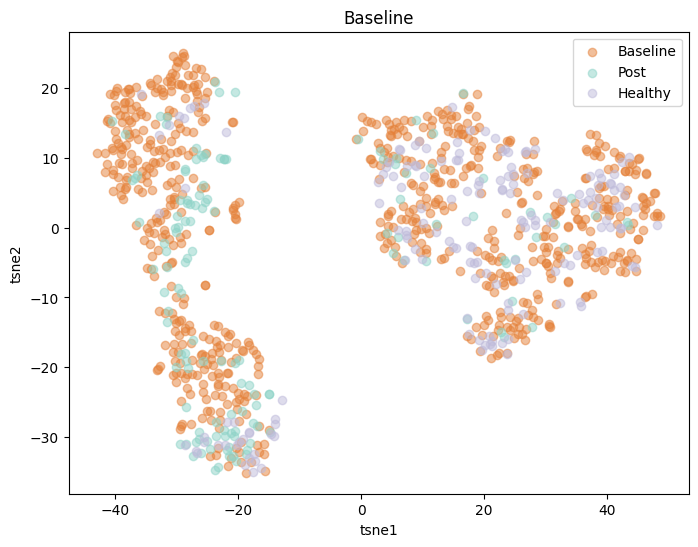

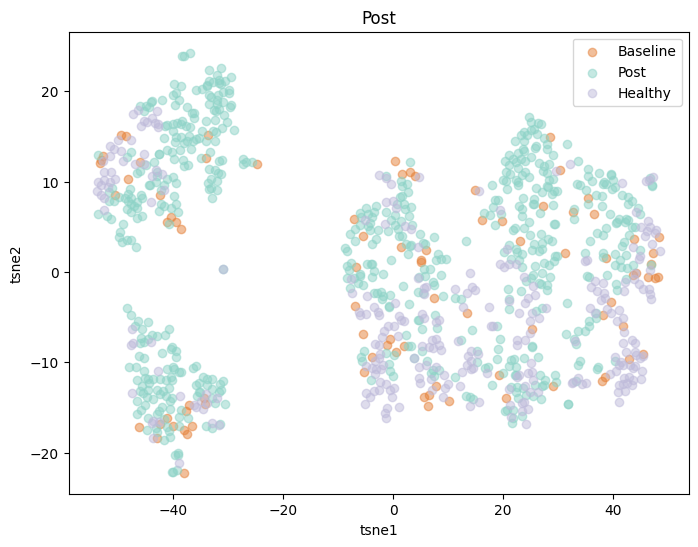

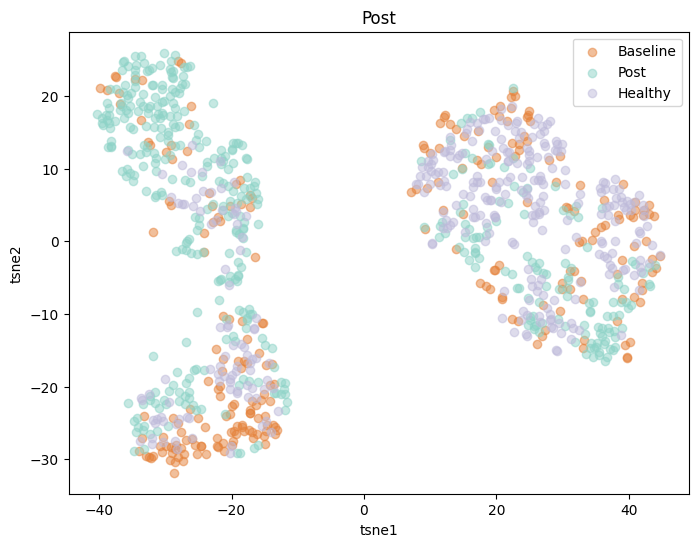

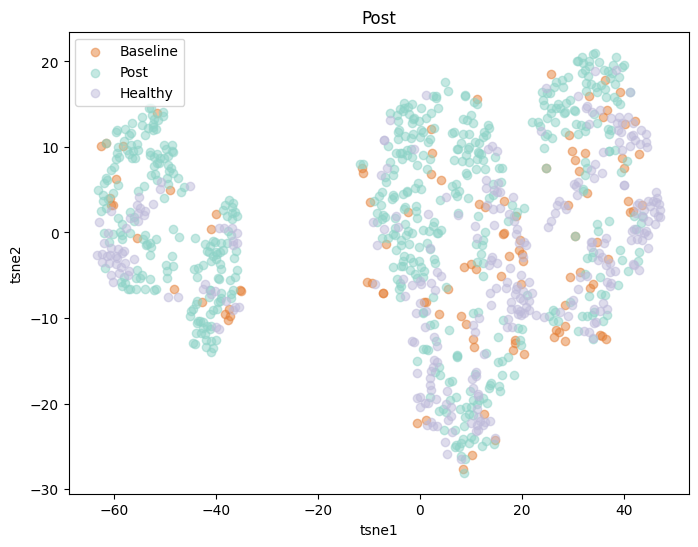

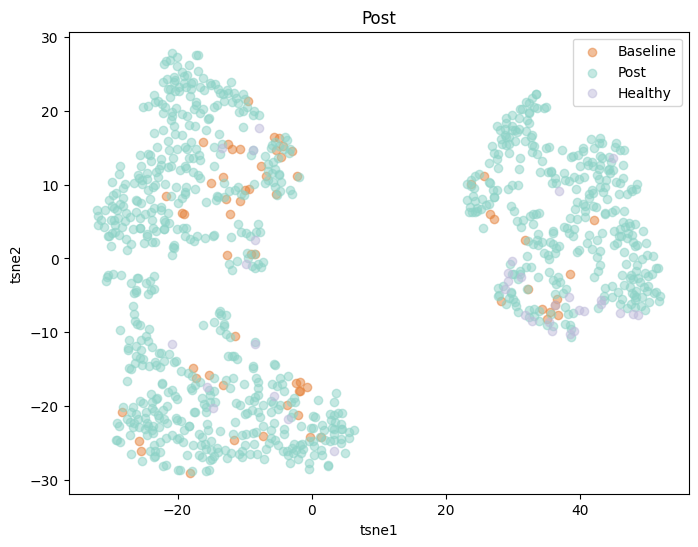

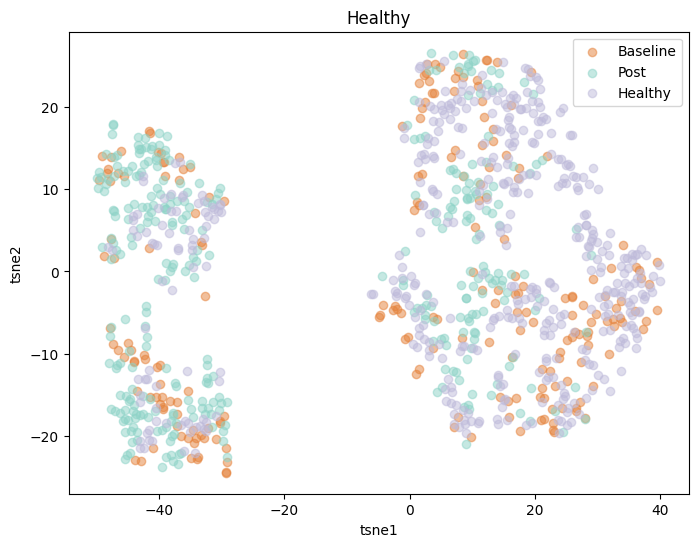

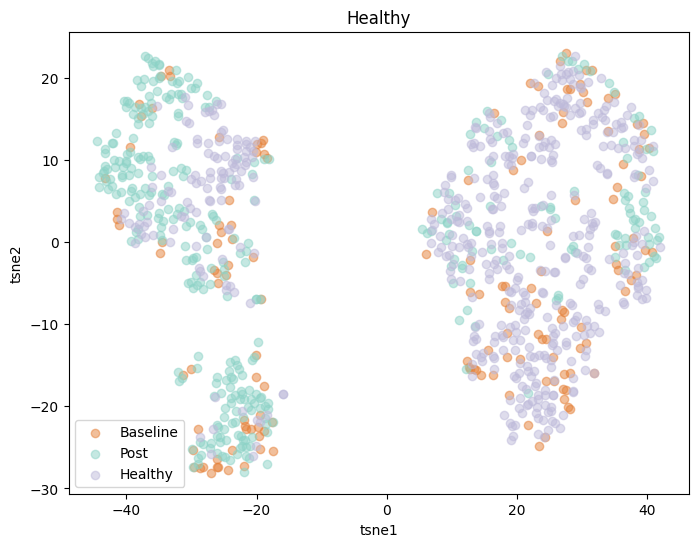

In [33]:
for patient_id in patient_predictions_noisy.iterrows():
    visualize_tsne_predictions(patient_id[1]['id_numeric'], test, final_model,final_features, group_labels, sample_size=1000)